# Conway's Game of life

![separator](img/sep.jpeg)

In [2]:
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d

First, we create a function that would create a *board*: for that, we use numpy’s [meshgrid](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html) function.

In [3]:
def create_board(size):
    """ Takes a tuple size (n,m) to create a board (n x m) """
    x = np.arange(0, size[0])
    y = np.arange(0, size[1])
    board = np.meshgrid(x, y)
    return board

We use `matplotlib`'s scatter function to plot our board. This would look like something like this:

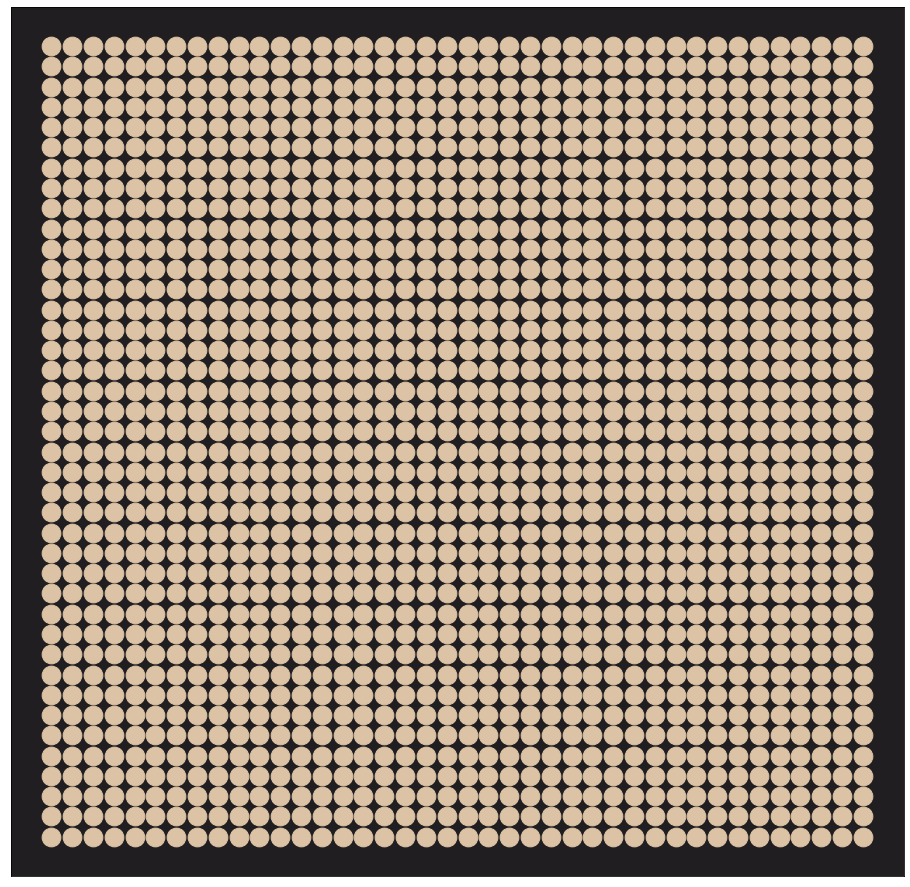

In [7]:
SIZE = (40,40)
marker_size = 350

board = create_board(SIZE)

fig, ax = plt.subplots(figsize=(16, 16))
scatter = ax.scatter(*board, animated=True, s=marker_size, edgecolor=None, c = '#ddc3a5')
ax.set_facecolor('#201e20')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

We represent the status *alive* or *dead* of each *cell* on the board as `True` and `False`. We also can give a starting probability in $[0,1) for living cells:

In [10]:
def status(size, prob_life):
    stat = (np.random.uniform(0, 1, size=size) >= prob_life)
    return stat

status(SIZE, prob_life=0.3)

array([[ True,  True, False, ...,  True, False, False],
       [ True,  True,  True, ..., False, False,  True],
       [False,  True, False, ...,  True, False,  True],
       ...,
       [ True,  True,  True, ...,  True,  True, False],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ..., False,  True,  True]])

Now, as a huge fan of Conway's work, his beautiful mind and his charimatic and genius approach to mathematics in general, I invite anyone reading this to have a look at his famous [Game of life](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life).

Conway came up with a set of rules for this game:

  * Survival : Any live cell with two or three live neighbors lives on to the next generation.
  * Under-population : Any live cell with fewer than two live neighbors dies.
  * Over-population : Any live cell with more than three live neighbors dies.
  * Reproduction : Any dead cell with exactly three live neighbors becomes a live cell.


So a cell has a total of 8 neighbouring cells : up, down, left, right and diagonals. We create a function that would apply these rules to a given game `status`.

We first create a function that will count how many living neighbours a cell has. 

A really nice way to do that is to think in the following way: what happens when we reach the edge of the board? Well this makes me think of the game Super MarioBros3 Battle mode on SNES when I was young. Every time Mario reached the edge of the screen, he would reappear in the other edge: This suggests that what we actually see as a board (or a TV screen in my case) is actually a *3D band*, where mario runs infinitely. 

We use `scipy`'s 2D wrapping function [`convolve2d`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html) to wrap the edges of the board, using the circular boundary conditions in the parameter : `boundary="wrap"`

In [11]:
def count_alive_neighbors(status):
    """ Counts the number of neighboring alive cells """
    kernel = np.array(
        [[1, 1, 1],
         [1, 0, 1],
         [1, 1, 1]])
    
    count = convolve2d(status, kernel, mode='same', boundary="wrap")
    return count

Now we can implement Conway's rules into a function:

In [12]:
def life_rules(status):
    """
    Applies Conway's Game of Life rules given the current status of the game and returns a tuple of two arrays: 
    a the new status of each cell and a representation of the number of its neighbors
    """
    alive_neighbors = count_alive_neighbors(status)
    
    # Under-population :
    survive_UP = ( alive_neighbors >= 2 )
    # Over-population :
    survive_OP = ( alive_neighbors <= 3 )
    # Survivors : 
    survive = status * survive_UP * survive_OP
    # Reproduction :
    new_status = np.where(alive_neighbors == 3, True, survive)
    
    new_neighbors = count_alive_neighbors(new_status)
    return new_status, new_neighbors

For visual reasons, we can colour the cells depending on the the number of neighbours they have:

In [13]:
def get_colors(status, count):
    cmap = mpl.cm.plasma
    rescale = count / 8 
    colors = [cmap(neighbors) for neighbors in rescale.flatten()]
    cell_alive = status.flatten()
    colors = [(r, g, b, 0.9) if cell else (r, g, b, 0) for cell, (r, g, b, a) in zip(cell_alive, colors)]
    return colors

Now, after spending hours reading and understanding `matplotlib.animation`'s [API](https://matplotlib.org/stable/api/animation_api.html), we can use the class `FuncAnimation` and tweak it a tiny bit to create a function that would retrun an instance of `FuncAnimation`:

In [16]:
def let_there_be_life(prob_life, size=(40, 40)):
    """ Implementing the Game of Life """
    board = create_board(size)
    stat = status(size, prob_life)

    fig, ax = plt.subplots(figsize=(16, 16))
    scatter = ax.scatter(*board, animated=True, s=350, edgecolor=None, c = '#ddc3a5')
    ax.set_facecolor('#ffcce7')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False);

    def update(frame):
        nonlocal stat
        stat, alive_neigbors = life_rules(stat)
        colors = get_colors(stat, alive_neigbors)
        scatter.set_facecolor(colors);
        return scatter

    return FuncAnimation(fig, update, frames = 500);

## LET THERE BE LIFE !

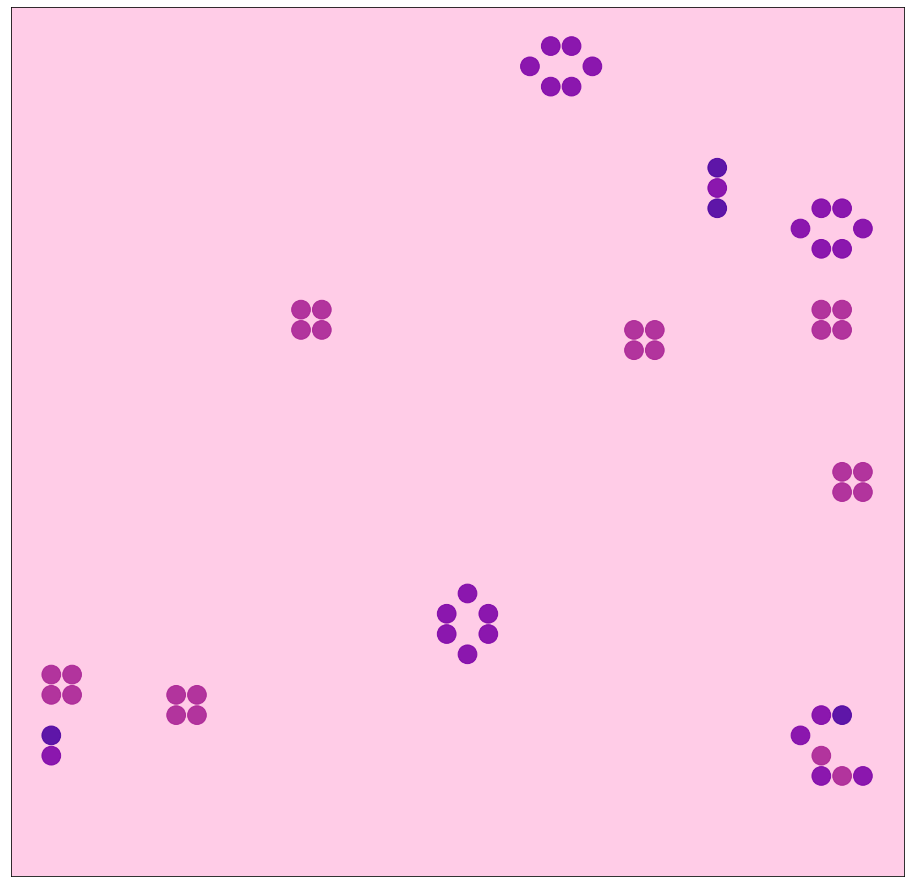

In [17]:
anim = let_there_be_life(prob_life=0.5)

HTML(anim.to_html5_video())

Optional: we can save it into a gif:

In [ ]:
anim.save('Game of life.gif', writer='pillow')